In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Leer los datos
data = pd.read_csv('../data/processed/medias3.csv')
df = pd.DataFrame(data)
df['fecha'] = pd.to_datetime(df['fecha'])

# Ordenar los datos por fecha
df.sort_values('fecha', inplace=True)

train_df = df[((df['fecha'] >= '2014-01-01') & (df['fecha'] <= '2015-12-31')) | ((df['fecha'] >= '2016-01-01') & (df['fecha'] <= '2023-12-31'))]
test_df = df[(df['fecha'] >= '2024-01-01') & (df['fecha'] <= '2024-06-1')]

# Seleccionar la columna 'ao' y normalizar los datos
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_train_data = scaler.fit_transform(train_df['ao'].values.reshape(-1, 1))
scaled_test_data = scaler.transform(test_df['ao'].values.reshape(-1, 1))

# Crear una función para preparar los datos
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

# Definir el paso de tiempo (lookback)
time_step = 10
X_train, y_train = create_dataset(scaled_train_data, time_step)
X_test, y_test = create_dataset(scaled_test_data, time_step)

# Redimensionar los datos para que sean compatibles con LSTM [samples, time steps, features]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Construir el modelo LSTM con Dropout
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(25))
model.add(Dense(1))

# Compilar el modelo
model.compile(optimizer='adam', loss='mean_squared_error')

# Implementar Early Stopping
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Entrenar el modelo solo con los datos de entrenamiento
history = model.fit(X_train, y_train, batch_size=1, epochs=100, validation_split=0.2, callbacks=[early_stop])

# Hacer predicciones con los datos de prueba
test_predict = model.predict(X_test)

# Crear un DataFrame con las predicciones y las fechas correspondientes
test_predictions = pd.DataFrame(test_predict, columns=['Predicted'], index=test_df.index[-len(test_predict):])

# Desnormalizar las predicciones y los valores reales
test_predictions['Predicted'] = scaler.inverse_transform(test_predictions[['Predicted']])
y_test = scaler.inverse_transform([y_test])

# Agregar las fechas al DataFrame de predicciones
test_predictions['Fecha'] = test_df['fecha'].values[-len(test_predict):]

# Exportar el DataFrame de predicciones a CSV
test_predictions.to_csv('test_predictions.csv', index=False)


Epoch 1/100


C:\Users\rmarc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2900/2900 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 0.0039 - val_loss: 7.4450e-05
Epoch 2/100
2900/2900 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 0.0012 - val_loss: 4.0070e-05
Epoch 3/100
2900/2900 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 9.6379e-04 - val_loss: 4.6740e-04
Epoch 4/100
2900/2900 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.0011 - val_loss: 8.0782e-05
Epoch 5/100
2900/2900 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 7.7230e-04 - val_loss: 3.6382e-05
Epoch 6/100
2900/2900 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 8.1973e-04 - val_loss: 7.1173e-05
Epoch 7/100
2900/2900 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 8.4822e-04 - val_loss: 3.5873e-05
Epoch 8/100
2900/2900 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 5.5666e-04 - val_loss: 3.3512e-05
Epoch 9/100
2900/2900 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 6.2953e-04 - val_loss: 9.1591e-05
Epoch 10/100
2900/2900 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 5.5914e-04 - val_loss: 2.5154e-04
Epoch 11/100
2900/2900 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/st

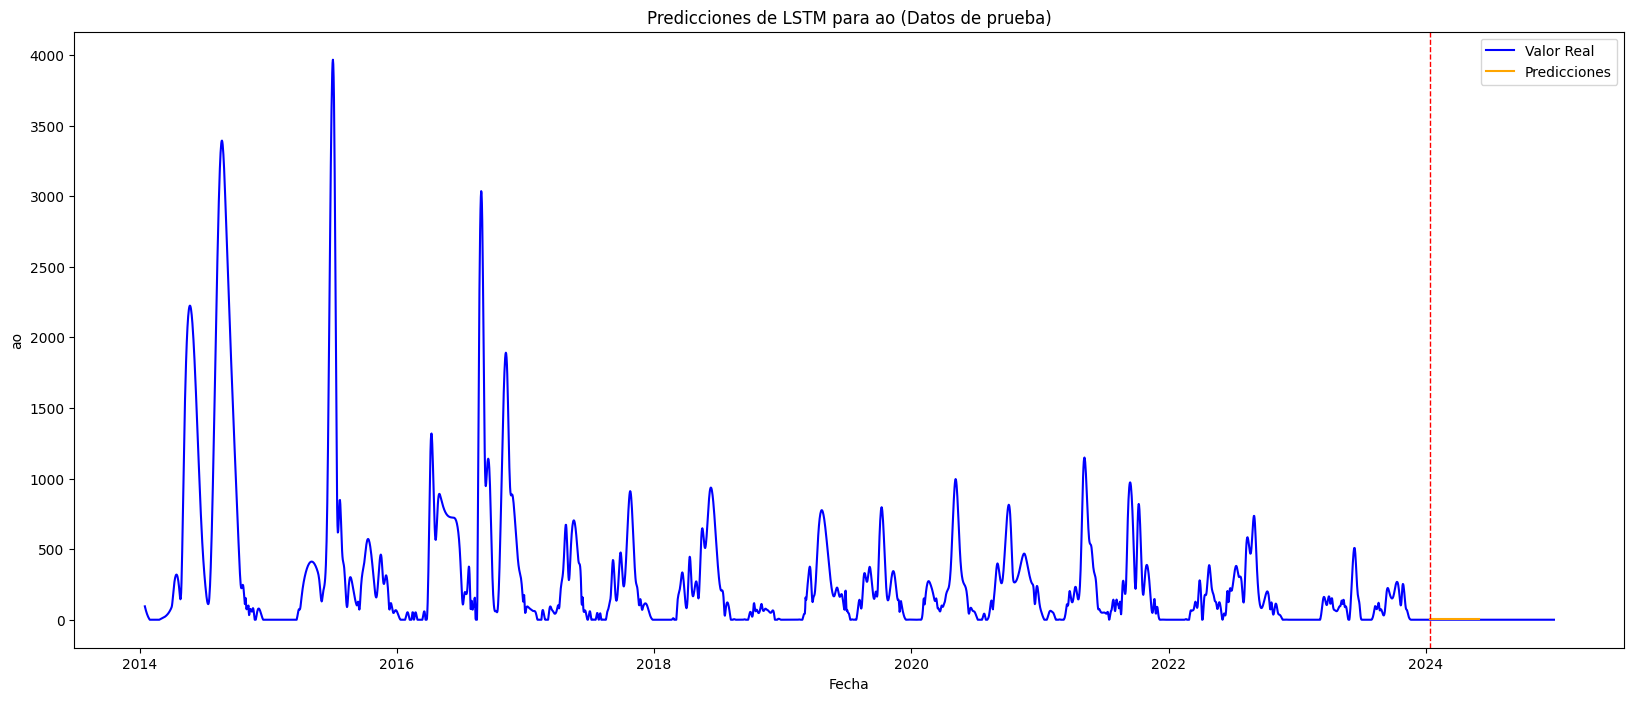

In [66]:

# Preparar las fechas para el gráfico
dates = df['fecha'].values
train_dates = train_df['fecha'].values
test_dates = test_df['fecha'][time_step + 1:].values
# Graficar los resultados
plt.figure(figsize=(20, 8))
plt.plot(dates, df['ao'], label='Valor Real', color='blue')
plt.plot(test_predictions['Fecha'], test_predictions['Predicted'], label='Predicciones', color='orange')
plt.axvline(x=test_dates[0], color='red', linestyle='--', linewidth=1)  # Línea para marcar el inicio de las predicciones
plt.legend()
plt.xlabel('Fecha')
plt.ylabel('ao')
plt.title('Predicciones de LSTM para ao (Datos de prueba)')
plt.show()

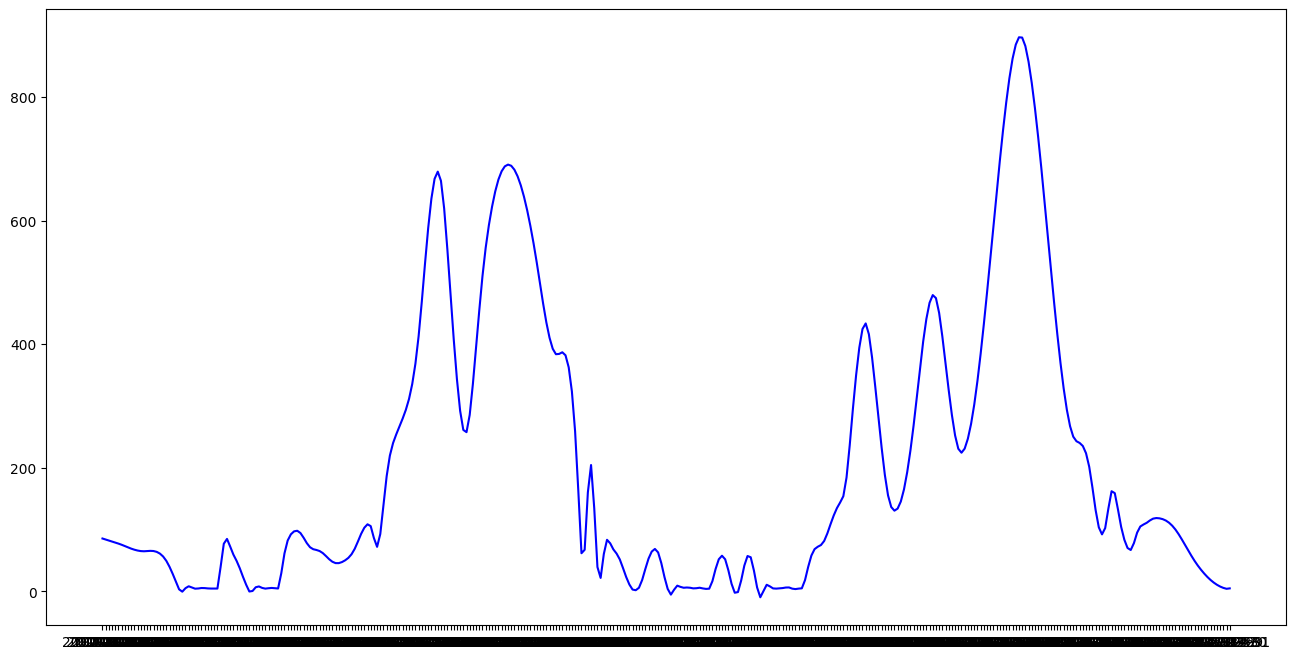

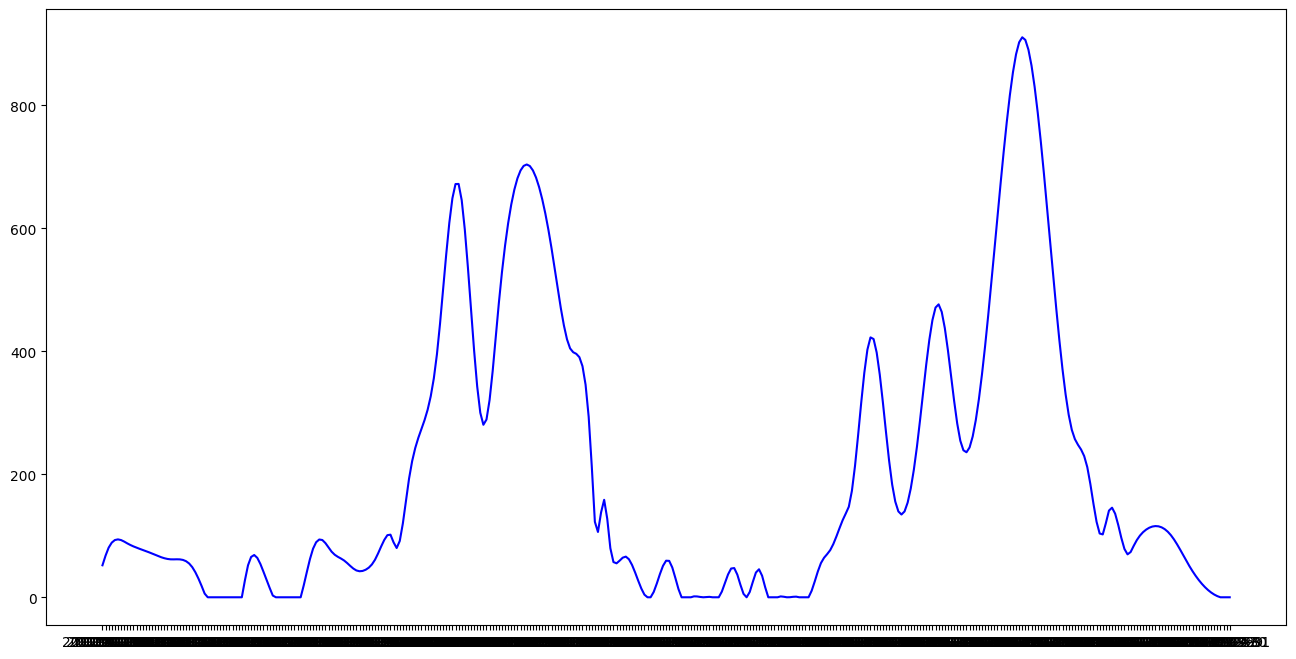

In [56]:
df2 = pd.read_csv('test_predictions.csv')
df3 = pd.read_csv('../data/processed/medias3_1.csv')

plt.figure(figsize=(16, 8))
plt.plot(df2['Fecha'], df2['Predicted'], label='Valor Real', color='blue')

plt.figure(figsize=(16, 8))
plt.plot(df3['fecha'], df3['ao'], label='Valor Real', color='blue')